In [1]:
import pandas as pd
import pybedtools
from ALLCools.mcds import MCDS
import glob
import joblib

In [2]:
gene_meta_path = '/home/qzeng/project/aging/metadata/gencode.vM22.basic.annotation.gene.flat.tsv.gz'
chrom_to_remove = ['chrM','chrY']

# change this to the path to your filtered metadata
metadata_path = '/home/qzeng/project/aging/metadata/240104_m3C_META.csv'

# change this to the paths to your MCDS files
obs_dim = 'cell'
var_dim = 'gene'

min_cov = 5

mcds_path = glob.glob('/ceph/gale-1/qzeng/AmbData/5kb_MCDS/F.MCDS/*.mcds/gene')

In [3]:
metadata = pd.read_csv(metadata_path, index_col = 0)

gene_name_to_id = joblib.load('240112_DMG_CEF/gene_name_to_id_dict')
gene_id_to_name = joblib.load('240112_DMG_CEF/gene_id_to_name_dict')

gene_meta = pd.read_csv(gene_meta_path, index_col ='gene_id', sep='\t')

## prepare male gene MCDS

In [4]:
genes_to_skip = set()

# skip smaller genes mostly covered by a larger gene, e.g., a miRNA within a protein coding gene.
# F=0.9 means > 90% of gene_b is overlapped with gene_a, in this case, we only keep gene_a for DMG test
# gene_bed = pybedtools.BedTool.from_dataframe(
#     gene_meta.reset_index()[['chrom', 'start', 'end', 'gene_id']])
# mapped_bam = gene_bed.map(b=gene_bed, c=4, o='distinct', F=0.9)
# for _, (*_, gene_a, gene_b_str) in mapped_bam.to_dataframe().iterrows():
#     for gene_b in gene_b_str.split(','):
#         if gene_b != gene_a:
#             genes_to_skip.add(gene_b)

# remove certain chromosomes
genes_to_skip |= set(gene_meta.index[gene_meta['chrom'].isin(chrom_to_remove)])
use_features = gene_meta.index[~gene_meta.index.isin(genes_to_skip)]
print(f'{use_features.size} features remained')

53881 features remained


In [5]:
mcds = MCDS.open(mcds_path, 
                 var_dim=var_dim,
                 use_obs=metadata.index
                )

In [6]:
all_ = mcds.get_index(var_dim)

In [7]:
use_features = list(set(mcds.get_index(var_dim)) & set(use_features))
len(use_features)

53881

In [8]:
joblib.dump(use_features,'tmp_use_features')

['tmp_use_features']

## select features

In [9]:
mcds = MCDS.open(mcds_path, 
                 var_dim= var_dim,
                 use_obs=metadata.index)

Feature gene mean cov across cells added in MCDS.coords['gene_cov_mean'].


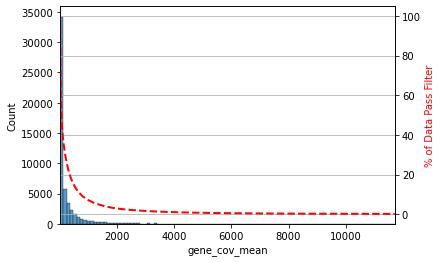

In [10]:
mcds.add_feature_cov_mean()

In [11]:
feature_cov_mean = mcds.coords[f'{var_dim}_cov_mean'].to_pandas()

In [12]:
use_features_2 = feature_cov_mean[feature_cov_mean > min_cov].index

In [13]:
mcds.filter_feature_by_cov_mean(min_cov=min_cov)

Before cov mean filter: 53881 gene
 After cov mean filter: 43511 gene 80.8%


<xarray.MCDS>
Dimensions:        (mc_type: 2, cell: 72666, count_type: 2, gene: 43511)
Coordinates:
  * mc_type        (mc_type) <U3 'CGN' 'CHN'
  * cell           (cell) <U43 'AMB_220719_18mo_13D_14C_2_P1-1-B11-A1' ... 'A...
  * count_type     (count_type) <U3 'mc' 'cov'
  * gene           (gene) object 'ENSMUSG00000102693.1' ... 'ENSMUSG000000938...
    gene_chrom     (gene) <U5 dask.array<chunksize=(10931,), meta=np.ndarray>
    gene_end       (gene) int64 dask.array<chunksize=(21850,), meta=np.ndarray>
    gene_start     (gene) int64 dask.array<chunksize=(21850,), meta=np.ndarray>
    gene_cov_mean  (gene) float64 9.525 4.631e+03 7.318 ... 49.45 301.5 121.6
Data variables:
    gene_da        (cell, gene, mc_type, count_type) uint32 dask.array<chunksize=(15, 10931, 1, 1), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  gene

In [14]:
use_features_1 = joblib.load('tmp_use_features')

In [15]:
use_features = list(set(use_features_1) & set(use_features_2))
len(use_features)

43511

In [16]:
f_mcds = mcds.sel(gene = mcds.get_index(var_dim).isin(use_features))

/home/qz/miniconda3/envs/allcools/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [17]:
f_mcds.add_mc_frac(normalize_per_cell=False, clip_norm_value=None)

In [18]:
f_mcds = f_mcds[['gene_da_frac']]
f_mcds['gene_da_frac'] = f_mcds['gene_da_frac'].astype('float32')

In [19]:
f_mcds.write_dataset(f'Female.genes_frac.mcds', var_dims=['gene'])

Saving gene
Saving chunk 0: 0 - 7266


/home/qz/miniconda3/envs/allcools/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Saving chunk 1: 7266 - 14532
Saving chunk 2: 14532 - 21798
Saving chunk 3: 21798 - 29064
Saving chunk 4: 29064 - 36330
Saving chunk 5: 36330 - 43596
Saving chunk 6: 43596 - 50862
Saving chunk 7: 50862 - 58128
Saving chunk 8: 58128 - 65394
Saving chunk 9: 65394 - 72660
Saving chunk 10: 72660 - 72666


In [ ]:
# mcds = MCDS.open(mcds_path, 
#                  var_dim= use_features.isin(mcds.get_index(var_dim)),
#                  use_obs=metadata.index).sel({var_dim: use_features})